# <font color = 'blue'> Experiment with RNN to improve the perplexity of the model



In [1]:
!pip install d2l==0.16.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76 kB 2.7 MB/s 
     |████████████████████████████████| 120 kB 20.8 MB/s 
     |████████████████████████████████| 1.6 MB 50.9 MB/s 
     |████████████████████████████████| 82 kB 979 kB/s 


In [2]:
%matplotlib inline
from d2l import torch as d2l
import math
import torch
from torch import nn
from torch.nn import functional as F

I began with the notebook that implements from scratch a simple RNN.

In [3]:
batch_size, num_steps = 2, 5
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [4]:
for X, y in train_iter:
  print(X)
  print(y)
  break


tensor([[ 1,  3,  5, 13,  2],
        [14, 11,  2,  1, 17]])
tensor([[ 3,  5, 13,  2,  1],
        [11,  2,  1, 17,  4]])


In [5]:
batch_size, num_steps = 28, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

## One-Hot Encoding

Each token is represented as a numerical index in `train_iter`.
Feeding these indices directly to a neural network might make it hard to
learn.
Each token is often represented as a more expressive feature vector.
The easiest representation is called *one-hot encoding*.



In [6]:
F.one_hot(torch.tensor([0, 2]), len(vocab))

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])

The shape of the minibatch that is sampled each time is (batch size, number of time steps).
The `one_hot` function transforms such a minibatch into a three-dimensional tensor with the last dimension equals to the vocabulary size (`len(vocab)`).
Often the input is transposed so that an output of shape
(number of time steps, batch size, vocabulary size) is obtained.
This will allow
to more conveniently
loop through the outermost dimension
for updating hidden states of a minibatch,
time step by time step.


In [11]:
X = torch.arange(10).reshape((2, 5))
F.one_hot(X.T, 28).shape

torch.Size([5, 2, 28])

## Initializing the Model Parameters

Next, the model parameters are initialized for
the RNN model.
The number of hidden units `num_hiddens` is a tunable hyperparameter.
When training language models,
the inputs and outputs are from the same vocabulary.
Hence, they have the same dimension,
which is equal to the vocabulary size.


In [8]:
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01

    # Hidden layer parameters
    W_xh = normal((num_inputs, num_hiddens))
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = torch.zeros(num_hiddens, device=device)

    # Output layer parameters
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    
    # Attach gradients
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

## RNN Model

To define an RNN model, first I need an `init_rnn_state` function
to return the hidden state at initialization.
It returns a tensor filled with 0 and with a shape of (batch size, number of hidden units).
Using tuples makes it easier to handle situations where the hidden state contains multiple variables,
which I will encounter in later sections.


In [9]:
def init_rnn_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device), )

The following `rnn` function defines how to compute the hidden state and output
at a time step.
Note that
the RNN model
loops through the outermost dimension of `inputs`
so that it updates hidden states `H` of a minibatch,
time step by time step.

In [10]:
def rnn(inputs, state, params):
    # Here `inputs` shape: (`num_steps`, `batch_size`, `vocab_size`)
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    # Shape of `X`: (`batch_size`, `vocab_size`)
    for X in inputs:
        H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h)
        Y = torch.mm(H, W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)

With all the needed functions being defined,
next I create a class to wrap these functions and store parameters for an RNN model implemented from scratch.


In [11]:
class RNNModelScratch: 
    """A RNN Model implemented from scratch."""
    def __init__(self, vocab_size, num_hiddens, device,
                 get_params, init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn

    def __call__(self, X, state):
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        return self.forward_fn(X, state, self.params)

    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)

Let's check whether the outputs have the correct shapes, e.g., to ensure that the dimensionality of the hidden state remains unchanged.


In [12]:
num_hiddens = 512
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                      init_rnn_state, rnn)
state = net.begin_state(X.shape[0], d2l.try_gpu())
Y, new_state = net(X.to(d2l.try_gpu()), state)
Y.shape, len(new_state), new_state[0].shape

(torch.Size([10, 28]), 1, torch.Size([2, 512]))

I can see that the output shape is (number of time steps $\times$ batch size, vocabulary size), while the hidden state shape remains the same, i.e., (batch size, number of hidden units).


## Prediction

Let's first define the prediction function
to generate new characters following
the user-provided `prefix`,
which is a string containing several characters.
When looping through these beginning characters in `prefix`,
I keep passing the hidden state
to the next time step without
generating any output.
This is called the *warm-up* period,
during which the model updates itself
(e.g., update the hidden state)
but does not make predictions.
After the warm-up period,
the hidden state is generally better than
its initialized value at the beginning.
So I generate the predicted characters and emit them.


In [13]:
def predict_ch8(prefix, num_preds, net, vocab, device):  
    """Generate new characters following the `prefix`."""
    state = net.begin_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape(
        (1, 1))
    for y in prefix[1:]:  # Warm-up period
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds):  # Predict `num_preds` steps
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

Now I can test the `predict_ch8` function.
I specify the prefix as `time traveller ` and have it generate 10 additional characters.
Given that I have not trained the network,
it will generate nonsensical predictions.


In [14]:
predict_ch8('time traveller ', 10, net, vocab, d2l.try_gpu())

'time traveller dmtobtobto'

## Gradient Clipping

<br>

In [15]:
def grad_clipping(net, theta):  
    """Clip the gradient."""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

## Training

Before training the model,
let's define a function to train the model in one epoch. Here are some non-standard aspects of it. 

1. Different sampling methods for sequential data (random sampling and sequential partitioning) will result in differences in the initialization of hidden states.
1. I clip the gradients before updating the model parameters. This ensures that the model does not diverge even when gradients blow up at some point during the training process.
1. I use perplexity to evaluate the model. This ensures that sequences of different length are comparable.


Specifically,
when sequential partitioning is used, I initialize the hidden state only at the beginning of each epoch.
Since the $i^\mathrm{th}$ subsequence example  in the next minibatch is adjacent to the current $i^\mathrm{th}$ subsequence example,
the hidden state at the end of the current minibatch
will be
used to initialize
the hidden state at the beginning of the next minibatch.
In this way,
historical information of the sequence
stored in the hidden state
might flow over
adjacent subsequences within an epoch.
However, the computation of the hidden state
at any point depends on all the previous minibatches
in the same epoch,
which complicates the gradient computation.
To reduce computational cost,
I detach the gradient before processing any minibatch
so that the gradient computation of the hidden state
is always limited to
the time steps in one minibatch. 

When using the random sampling,
I need to re-initialize the hidden state for each iteration since each example is sampled with a random position.



In [16]:

def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    """Train a net within one epoch (defined in Chapter 8)."""
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)  # Sum of training loss, no. of tokens
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # Initialize `state` when either it is the first iteration or
            # using random sampling
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                # `state` is a tensor for `nn.GRU`
                state.detach_()
            else:
                # `state` is a tuple of tensors for `nn.LSTM` and
                # for custom scratch implementation
                for s in state:
                    s.detach_()
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net, 1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 1)
            # Since the `mean` function has been invoked
            updater(batch_size=1)
        metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

The training function supports an RNN model implemented
either from scratch or using high-level APIs.


In [17]:

def train_ch8(net, train_iter, vocab, lr, num_epochs, device,
              use_random_iter=False):
    """Train a model (defined in Chapter 8)."""
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    # Initialize
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)
    # Train and predict
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(
            net, train_iter, loss, updater, device, use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    print(f'perplexity {ppl:.1f}, {speed:.1f} tokens/sec on {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))

Now I can train the RNN model.
Since I only use 10000 tokens in the dataset, the model needs more epochs to converge better.


perplexity 1.2, 78760.7 tokens/sec on cuda:0
time traveller held in his hand was a glitteringmetallic framewo
traveller held in his hand was a glitteringmetallic framewo


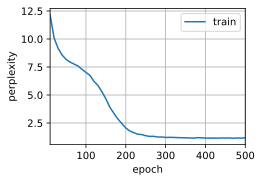

In [18]:
num_epochs, lr = 500, 1
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu())

Finally,
let's check the results of using the random sampling method.


perplexity 1.4, 81276.0 tokens/sec on cuda:0
time traveller proceeded anyreal body must have extension in fou
traveller proceeded anyreal body must have extension in fou


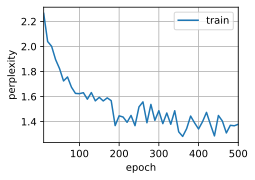

In [19]:
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu(),
          use_random_iter=True)

<font color = 'blue'>  The model has a number of hyperparameters, e.g. number of epochs, number of hidden units, number of steps in minibatch, and learning rate. Adjust these hyperparameters and try to improve the perplexity of the model.

In [20]:
batch_size, num_steps = 28, 50
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

perplexity 1.0, 82132.8 tokens/sec on cuda:0
time traveller with a slight accession ofcheerfulness really thi
traveller with a slight accession ofcheerfulness really thi


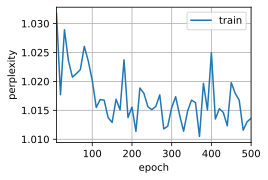

In [21]:
num_epochs, lr = 500, 1
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu())

In [24]:
batch_size, num_steps = 28, 300
train_iter_1, vocab = d2l.load_data_time_machine(batch_size, num_steps)

perplexity 1.0, 93131.6 tokens/sec on cuda:0
time traveller for so it will be convenient to speak of himwas e
traveller with a slight accession ofcheerfulness really thi


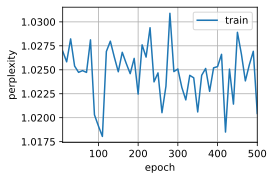

In [25]:
num_epochs, lr = 500, 1
train_ch8(net, train_iter_1, vocab, lr, num_epochs, d2l.try_gpu())

perplexity 1.0, 89266.1 tokens/sec on cuda:0
time traveller for so it will be convenient to speak of himwas e
travelleryou can show black is white by argument said filby


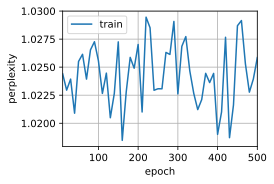

In [26]:
num_epochs, lr = 500, 0.001
train_ch8(net, train_iter_1, vocab, lr, num_epochs, d2l.try_gpu())

In [33]:
num_hiddens = 2000
net4 = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                      init_rnn_state, rnn)
state = net4.begin_state(X.shape[0], d2l.try_gpu())
Y, new_state = net4(X.to(d2l.try_gpu()), state)
Y.shape, len(new_state), new_state[0].shape

(torch.Size([10, 28]), 1, torch.Size([2, 2000]))

In [34]:
batch_size, num_steps = 28, 300
train_iter4, vocab = d2l.load_data_time_machine(batch_size, num_steps)

perplexity 6.7, 46562.1 tokens/sec on cuda:0
time travellere mene and the pare the that of he which andimenst
travellere mone aime than there we thavely anous able the t


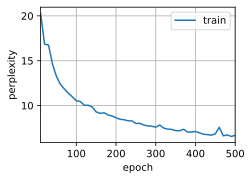

In [35]:
num_epochs, lr = 500, 1
train_ch8(net4, train_iter4, vocab, lr, num_epochs, d2l.try_gpu())

In [36]:
num_hiddens = 512
net5 = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                      init_rnn_state, rnn)
state = net5.begin_state(X.shape[0], d2l.try_gpu())
Y, new_state = net5(X.to(d2l.try_gpu()), state)
Y.shape, len(new_state), new_state[0].shape

(torch.Size([10, 28]), 1, torch.Size([2, 512]))

In [37]:
batch_size, num_steps = 28, 35
train_iter5, vocab = d2l.load_data_time_machine(batch_size, num_steps)

perplexity 1.2, 77304.0 tokens/sec on cuda:0
time traveller wmic beend trererisat larn onstant of its occurut
traveller with u anend brags of rlacnofree of the trammels 


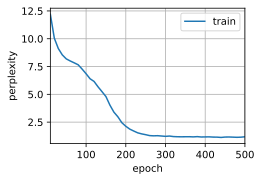

In [38]:
num_epochs, lr = 500, 1
train_ch8(net5, train_iter5, vocab, lr, num_epochs, d2l.try_gpu())

In [39]:
num_hiddens = 2000
net6 = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                      init_rnn_state, rnn)
state = net6.begin_state(X.shape[0], d2l.try_gpu())
Y, new_state = net6(X.to(d2l.try_gpu()), state)
Y.shape, len(new_state), new_state[0].shape

(torch.Size([10, 28]), 1, torch.Size([2, 2000]))

In [40]:
batch_size, num_steps = 28, 35
train_iter6, vocab = d2l.load_data_time_machine(batch_size, num_steps)

perplexity 1.2, 43377.6 tokens/sec on cuda:0
time traveller for so it wallexp reeved tour ghabright and soft 
traveller for so it wall bp convenient to speak of himwas e


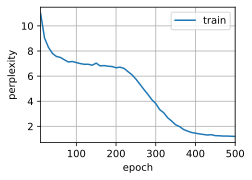

In [41]:
num_epochs, lr = 500, 1
train_ch8(net6, train_iter6, vocab, lr, num_epochs, d2l.try_gpu())

In [42]:
num_hiddens = 2000
net7 = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                      init_rnn_state, rnn)
state = net7.begin_state(X.shape[0], d2l.try_gpu())
Y, new_state = net7(X.to(d2l.try_gpu()), state)
Y.shape, len(new_state), new_state[0].shape

(torch.Size([10, 28]), 1, torch.Size([2, 2000]))

In [43]:
batch_size, num_steps = 28, 15
train_iter7, vocab = d2l.load_data_time_machine(batch_size, num_steps)

perplexity 1.4, 40480.7 tokens/sec on cuda:0
time traveller proceeded antres thath mis cauthere the balloons 
traveller smiled are you sure we can move terellare these m


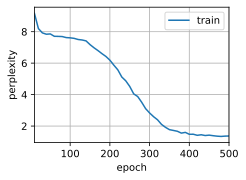

In [44]:
num_epochs, lr = 500, 1
train_ch8(net7, train_iter7, vocab, lr, num_epochs, d2l.try_gpu())

In [45]:
num_hiddens = 2000
net8 = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                      init_rnn_state, rnn)
state = net8.begin_state(X.shape[0], d2l.try_gpu())
Y, new_state = net8(X.to(d2l.try_gpu()), state)
Y.shape, len(new_state), new_state[0].shape

(torch.Size([10, 28]), 1, torch.Size([2, 2000]))

In [46]:
batch_size, num_steps = 28, 85
train_iter8, vocab = d2l.load_data_time_machine(batch_size, num_steps)

perplexity 1.3, 44988.1 tokens/sec on cuda:0
time traveller parded thereaid the medic joman shef thar pand de
traveller among call nith eop is to ans te tacrat so shands


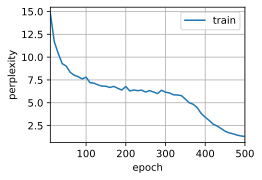

In [47]:
num_epochs, lr = 500, 1
train_ch8(net8, train_iter8, vocab, lr, num_epochs, d2l.try_gpu())

In [48]:
num_hiddens = 700
net9 = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                      init_rnn_state, rnn)
state = net9.begin_state(X.shape[0], d2l.try_gpu())
Y, new_state = net9(X.to(d2l.try_gpu()), state)
Y.shape, len(new_state), new_state[0].shape

(torch.Size([10, 28]), 1, torch.Size([2, 700]))

In [49]:
batch_size, num_steps = 28, 55
train_iter9, vocab = d2l.load_data_time_machine(batch_size, num_steps)

perplexity 1.0, 80472.9 tokens/sec on cuda:0
time traveller for so it will be convenient to speak of himwas e
traveller for so it will be convenient to speak of himwas e


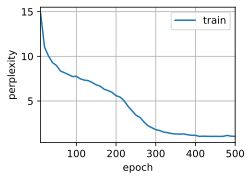

In [50]:
num_epochs, lr = 500, 1
train_ch8(net9, train_iter9, vocab, lr, num_epochs, d2l.try_gpu())

In [55]:
num_hiddens = 900
net10 = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                      init_rnn_state, rnn)
state = net10.begin_state(X.shape[0], d2l.try_gpu())
Y, new_state = net10(X.to(d2l.try_gpu()), state)
Y.shape, len(new_state), new_state[0].shape

(torch.Size([10, 28]), 1, torch.Size([2, 900]))

In [56]:
batch_size, num_steps = 28, 55
train_iter10, vocab = d2l.load_data_time_machine(batch_size, num_steps)

perplexity 1.0, 85462.1 tokens/sec on cuda:0
time traveller for so it will be convenient to speak of himwas e
traveller with a slight accession ofcheerfulness really thi


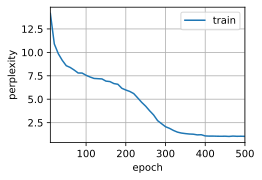

In [57]:
num_epochs, lr = 500, 1
train_ch8(net10, train_iter10, vocab, lr, num_epochs, d2l.try_gpu())

In [59]:
num_hiddens = 900
net11 = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                      init_rnn_state, rnn)
state = net11.begin_state(X.shape[0], d2l.try_gpu())
Y, new_state = net11(X.to(d2l.try_gpu()), state)
Y.shape, len(new_state), new_state[0].shape

(torch.Size([10, 28]), 1, torch.Size([2, 900]))

In [60]:
batch_size, num_steps = 28, 55
train_iter11, vocab = d2l.load_data_time_machine(batch_size, num_steps)

perplexity 13.6, 89957.4 tokens/sec on cuda:0
time traveller the the the the the the the the the the the the t
traveller the the the the the the the the the the the the t


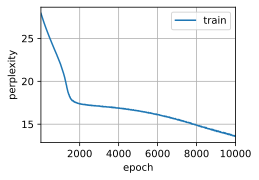

In [61]:
num_epochs, lr = 10000, 0.001
train_ch8(net11, train_iter11, vocab, lr, num_epochs, d2l.try_gpu())

In [62]:
num_hiddens = 900
net12 = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                      init_rnn_state, rnn)
state = net12.begin_state(X.shape[0], d2l.try_gpu())
Y, new_state = net12(X.to(d2l.try_gpu()), state)
Y.shape, len(new_state), new_state[0].shape

(torch.Size([10, 28]), 1, torch.Size([2, 900]))

In [63]:
batch_size, num_steps = 28, 55
train_iter12, vocab = d2l.load_data_time_machine(batch_size, num_steps)

perplexity 1.0, 88104.4 tokens/sec on cuda:0
time traveller for so it will be convenient to speak of himwas e
traveller with a slight accession ofcheerfulness really thi


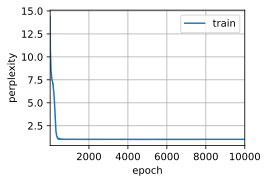

In [64]:
num_epochs, lr = 10000, 1
train_ch8(net12, train_iter12, vocab, lr, num_epochs, d2l.try_gpu())

**The experimental data is given below. The best perplexity I was able to achieve is 1.0.**

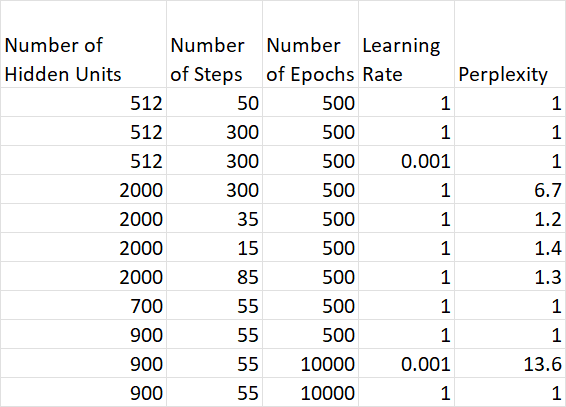

<font color = 'blue'> Replace the one-hot encoding with a set of learnable parameters (embedding).
<font color = 'blue'>  

In [78]:
batch_size, num_steps = 28, 50
train_iter13, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [79]:
for X, y in train_iter13:
  print(X)
  print(y)
  break

tensor([[17,  2, 12,  ...,  2,  6,  5],
        [21,  2,  5,  ..., 10,  1,  3],
        [ 1, 16,  2,  ...,  9,  4, 22],
        ...,
        [ 3,  1, 12,  ...,  9,  3,  1],
        [ 6,  1,  4,  ...,  4,  8,  1],
        [ 1,  9,  2,  ..., 13,  3,  9]])
tensor([[ 2, 12, 12,  ...,  6,  5,  2],
        [ 2,  5,  6,  ...,  1,  3,  9],
        [16,  2, 15,  ...,  4, 22,  2],
        ...,
        [ 1, 12,  7,  ...,  3,  1,  7],
        [ 1,  4,  1,  ...,  8,  1,  5],
        [ 9,  2,  4,  ...,  3,  9,  2]])


In [62]:
from sklearn.preprocessing import LabelEncoder

In [80]:
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01

    # Hidden layer parameters
    W_xh = normal((num_inputs, num_hiddens))
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = torch.zeros(num_hiddens, device=device)

    # Output layer parameters
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    
    # Attach gradients
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

In [81]:
def init_rnn_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device), )

In [82]:
def rnn(inputs, state, params):
    # Here `inputs` shape: (`num_steps`, `batch_size`, `vocab_size`)
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    # Shape of `X`: (`batch_size`, `vocab_size`)
    for X in inputs:
      
        H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h)
        
        Y = torch.mm(H, W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)

In [83]:
class RNNModelScratch: 
    """A RNN Model implemented from scratch."""
    def __init__(self, vocab_size, num_hiddens, device,
                 get_params, init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn
        self.E= nn.Embedding( self.vocab_size,28,device='cuda:0') 

    def __call__(self, X, state):
        #X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
       
        X=self.E(X.T).type(torch.float32)
        
        return self.forward_fn(X, state, self.params)

    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)

In [84]:
num_hiddens = 512
net13 = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                      init_rnn_state, rnn)



In [85]:
state = net13.begin_state(X.shape[0], d2l.try_gpu())
Y, new_state = net13(X.to(d2l.try_gpu()), state)
Y.shape, len(new_state), new_state[0].shape

(torch.Size([1400, 28]), 1, torch.Size([28, 512]))

In [86]:
def predict_ch8(prefix, num_preds, net, vocab, device):  
    """Generate new characters following the `prefix`."""
    state = net.begin_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape(
        (1, 1))
    for y in prefix[1:]:  # Warm-up period
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds):  # Predict `num_preds` steps
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

In [87]:
predict_ch8('time traveller ', 50, net13, vocab, d2l.try_gpu())

'time traveller giqgiqgiqgiqgiqgiqgiqgiqgiqgiqgiqgiqgiqgiqgiqgiqgi'

In [88]:
def grad_clipping(net, theta):  
    """Clip the gradient."""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

In [89]:
def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    """Train a net within one epoch (defined in Chapter 8)."""
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)  # Sum of training loss, no. of tokens
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # Initialize `state` when either it is the first iteration or
            # using random sampling
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                # `state` is a tensor for `nn.GRU`
                state.detach_()
            else:
                # `state` is a tuple of tensors for `nn.LSTM` and
                # for custom scratch implementation
                for s in state:
                    s.detach_()
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net, 1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 1)
            # Since the `mean` function has been invoked
            updater(batch_size=1)
        metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

In [90]:
def train_ch8(net, train_iter, vocab, lr, num_epochs, device,
              use_random_iter=False):
    """Train a model (defined in Chapter 8)."""
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    # Initialize
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)
    # Train and predict
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(
            net, train_iter, loss, updater, device, use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    print(f'perplexity {ppl:.1f}, {speed:.1f} tokens/sec on {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))

perplexity 1.0, 77479.2 tokens/sec on cuda:0
time traveller for so it will be convenient to speak of himwas e
traveller for so it will be convenient to speak of himwas e


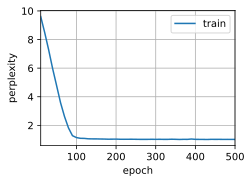

In [91]:
num_epochs, lr = 500, 1
train_ch8(net13, train_iter13, vocab, lr, num_epochs, d2l.try_gpu())

In [92]:
num_hiddens = 900
net14 = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                      init_rnn_state, rnn)
state = net14.begin_state(X.shape[0], d2l.try_gpu())
Y, new_state = net14(X.to(d2l.try_gpu()), state)
Y.shape, len(new_state), new_state[0].shape


(torch.Size([1400, 28]), 1, torch.Size([28, 900]))

In [93]:
batch_size, num_steps = 28, 55
train_iter14, vocab = d2l.load_data_time_machine(batch_size, num_steps)


perplexity 1.0, 83371.4 tokens/sec on cuda:0
time traveller for so it will be convenient to speak of himwas e
traveller for so it will be convenient to speak of himwas e


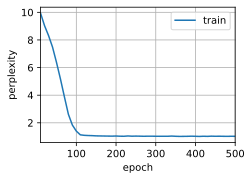

In [94]:
num_epochs, lr = 500, 1
train_ch8(net14, train_iter14, vocab, lr, num_epochs, d2l.try_gpu())

The perplexity remains 1.0 after using learnable embeddings. Convergence was faster when learnable embeddings are used. It converged from 100 epochs when learnable embeddings are used. It converged from 400 epochs when One Hot Encoding was used.

<font color = 'blue'>  Experiment by sampling the next character according to the probabilities generated by the model using numpy.random.choice.

In [150]:
import numpy as np

In [195]:
def predict_ch8(prefix, num_preds, net, vocab, device):  
    """Generate new characters following the `prefix`."""
    state = net.begin_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]]
    outputs1 = [vocab[prefix[0]]]
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape(
        (1, 1))
    for y in prefix[1:]:  # Warm-up period
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
        outputs1.append(vocab[y])
    for _ in range(num_preds):  # Predict `num_preds` steps
        y, state = net(get_input(), state)
        #print("hello")
        #print(y)
        sm = torch.nn.Softmax(dim=1)
        y1=sm(y)
        y2=y1.cpu()
        y3=y2.detach().numpy()
        
        y31=np.random.choice(y3.flatten(),1)
        #print(y31)
        result = np.where(y3 == y31)
        #print(result[-1])
        y4=result[-1]
        #print("postsoftmax")
        y5=torch.from_numpy(y4).cuda()
        outputs.append(int(y.argmax(dim=1).reshape(1)))
        outputs1.append(int(y5.reshape(1)))
        #print("predict")
        #print(outputs)
        #print(outputs1)
    return ''.join([vocab.idx_to_token[i] for i in outputs])

In [196]:
predict_ch8('time traveller ', 50, net13, vocab, d2l.try_gpu())

'time traveller for so it will be convenient to speak of himwas ex'

perplexity 1.0, 76641.6 tokens/sec on cuda:0
time traveller for so it will be convenient to speak of himwas e
traveller with a slight accession ofcheerfulness really thi


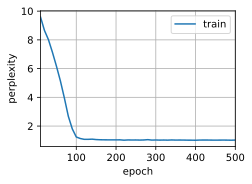

In [197]:
num_hiddens = 900
net15 = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                      init_rnn_state, rnn)
state = net15.begin_state(X.shape[0], d2l.try_gpu())
Y, new_state = net15(X.to(d2l.try_gpu()), state)
Y.shape, len(new_state), new_state[0].shape


batch_size, num_steps = 28, 55
train_iter15, vocab = d2l.load_data_time_machine(batch_size, num_steps)


num_epochs, lr = 500, 1
train_ch8(net15, train_iter15, vocab, lr, num_epochs, d2l.try_gpu())




In [198]:
predict_ch8('time traveller ', 50, net15, vocab, d2l.try_gpu())

'time traveller for so it will be convenient to speak of himwas ex'

The perplexity remains 1.0.